## This is a step-by-step commented kernel to approach simple EDA and baseline modeling on this competition and other NLP competitions.

## Special thanks to Dieter and his work on this competition. I would also like to thank Andrew Lukyanenko for his [advice](https://www.kaggle.com/general/89512) on writing good kernels.

## Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import os
import gc

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim

from sklearn.model_selection import KFold

from keras.layers import *
from keras.initializers import *
from keras.constraints import *
from keras.regularizers import *
from keras.activations import *
from keras.optimizers import *
import keras.backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.


## Download data

In [2]:
train_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

## Initialize constants for data extraction and training

In [3]:
TEXT_COL = 'comment_text'
EMB_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
MAXLEN = 128
ENDLEN = 32
MAX_FEATURES = 100000
EMBED_SIZE = 300
BATCH_SIZE = 2048
NUM_EPOCHS = 100

## Basic EDA

## Number of characters in the sentence

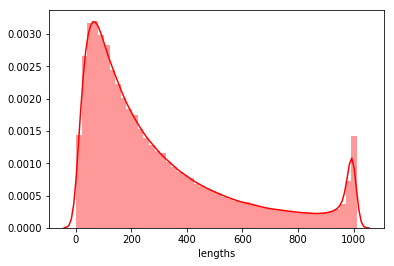

In [4]:
lengths = train_df[TEXT_COL].apply(len)
train_df['lengths'] = lengths
lengths = train_df.loc[train_df['lengths']<1125]['lengths']
sns.distplot(lengths, color='r')
plt.show()

### Here, we seem to have a bimodal distribution of character length in the data. Although the lengths seem to be heavily skewed to the lower lengths, wee see another clear peak around the 1000 character mark.

## Number of words in the sentence

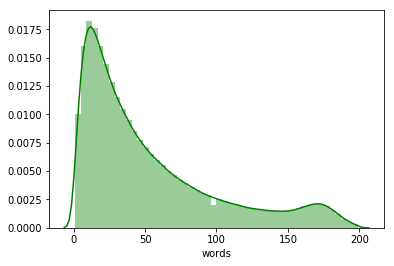

In [5]:
words = train_df[TEXT_COL].apply(lambda x: len(x) - len(''.join(x.split())) + 1)
train_df['words'] = words
words = train_df.loc[train_df['words']<200]['words']
sns.distplot(words, color='g')
plt.show()

### It looks like we have a clear unimodal left-skewed distribution of the number of words in the data.

## Average Word Length

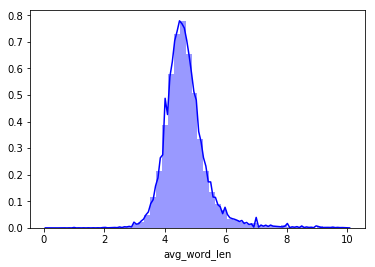

In [6]:
avg_word_len = train_df[TEXT_COL].apply(lambda x: 1.0*len(''.join(x.split()))/(len(x) - len(''.join(x.split())) + 1))
train_df['avg_word_len'] = avg_word_len
avg_word_len = train_df.loc[train_df['avg_word_len']<10]['avg_word_len']
sns.distplot(avg_word_len, color='b')
plt.show()

### We have a simple bell-shaped normal distribution of the average word length with a mean of around 4.5

## Sentiment (negativity)
### The orange is label 0 (non-toxic) and the purple is label 1 (toxic).

In [7]:
SIA = SentimentIntensityAnalyzer()
polarity_0 = train_df.loc[train_df.target<0.5][TEXT_COL].apply(lambda x: SIA.polarity_scores(x))
polarity_1 = train_df.loc[train_df.target>0.5][TEXT_COL].apply(lambda x: SIA.polarity_scores(x))

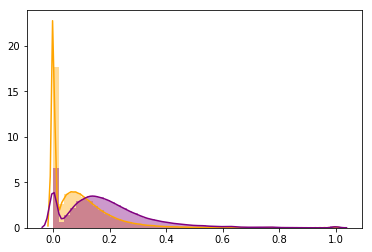

In [8]:
sns.distplot([polarity['neg'] for polarity in polarity_0], color='orange')
sns.distplot([polarity['neg'] for polarity in polarity_1], color='purple')
plt.show()

### Clearly, the purple distribution has a higher mean than the orange distribution. Both distributions have a somewhat equal spread (standard deviation). Although both distributions are skewed leftwards, the orange distribution has a stronger leftward skew.
## This shows that the label 1 (toxic) samples generally tend to be more negative on average.

## Sentiment (neutrality)

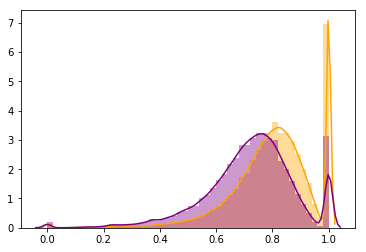

In [9]:
sns.distplot([polarity['neu'] for polarity in polarity_0], color='orange')
sns.distplot([polarity['neu'] for polarity in polarity_1], color='purple')
plt.show()

### The orange clearly has a higher mean than the purple distribution. Both distributions have a somewhat equal spread (standard deviation). Although both distributions are skewed rightwards, the orange distribution has a stronger rightward skew.
## This shows that the label 0 (non-toxic) samples generally tend to be more neutral on average.

### I tried to use a spelling corrector, but it did not improve the model's performance. The code for spelling correction is below.

In [10]:
print(''' # https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
spell_model = gensim.models.KeyedVectors.load_word2vec_format('../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec')
words = spell_model.index2word
w_rank = {}

for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

# Use fast text as vocabulary


def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]]) ''')

 # https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
spell_model = gensim.models.KeyedVectors.load_word2vec_format('../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec')
words = spell_model.index2word
w_rank = {}

for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

# Use fast text as vocabulary


def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):


## Functions for creating the embedding matrix

In [11]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_embedding_matrix(word_index, embeddings_index, MAX_FEATURES, lower = True, verbose = True):
    embedding_matrix = np.zeros((MAX_FEATURES, EMBED_SIZE))
    for word, i in tqdm(word_index.items(),disable = not verbose):
        if lower:
            word = word.lower()
        if i >= MAX_FEATURES: continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            embedding_vector = embeddings_index["unknown"]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

## Tokenize and pad the sentences

In [12]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)
tokenizer.fit_on_texts(list(train_df[TEXT_COL]) + list(test_df[TEXT_COL]))
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(list(train_df[TEXT_COL]))
X_test = tokenizer.texts_to_sequences(list(test_df[TEXT_COL]))


X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test = pad_sequences(X_test, maxlen=MAXLEN)

y_train = train_df['target'].values

del tokenizer
gc.collect()

0

## Load the embeddings

In [13]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embeddings_index)
del embeddings_index
gc.collect()

2000001it [03:09, 10537.00it/s]


0

## Create the Weighted Average Attention layer
### This layer computes a weighted average of the channels of the 3D input (from the recurrent layer) across timesteps. It performs better than the Attention layer most kernels are using

In [14]:
# https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

## Create the Capsule layer
### The classic Capsule layer as proposed by Geoffrey Hinton in 2017. This implementation is taken from [here](https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/capsule.py) on keras-contrib.

In [15]:
class Capsule(Layer):
    """Capsule Layer implementation in Keras
       This implementation is based on Dynamic Routing of Capsules,
       Geoffrey Hinton et. al.
       The Capsule Layer is a Neural Network Layer which helps
       modeling relationships in image and sequential data better
       than just CNNs or RNNs. It achieves this by understanding
       the spatial relationships between objects (in images)
       or words (in text) by encoding additional information
       about the image or text, such as angle of rotation,
       thickness and brightness, relative proportions etc.
       This layer can be used instead of pooling layers to
       lower dimensions and still capture important information
       about the relationships and structures within the data.
       A normal pooling layer would lose a lot of
       this information.
       This layer can be used on the output of any layer
       which has a 3-D output (including batch_size). For example,
       in image classification, it can be used on the output of a
       Conv2D layer for Computer Vision applications. Also,
       it can be used on the output of a GRU or LSTM Layer
       (Bidirectional or Unidirectional) for NLP applications.
       The default activation function is 'linear'. But, this layer
       is generally used with the 'squash' activation function
       (recommended). To use the squash activation function, do :
       from keras_contrib.activations import squash
       capsule = Capsule(num_capsule=10,
                         dim_capsule=10,
                         routings=3,
                         share_weights=True,
                         activation=squash)
       # Example usage :
           1). COMPUTER VISION
           input_image = Input(shape=(None, None, 3))
           conv_2d = Conv2D(64,
                            (3, 3),
                            activation='relu')(input_image)
           capsule = Capsule(num_capsule=10,
                             dim_capsule=16,
                             routings=3,
                             activation='relu',
                             share_weights=True)(conv_2d)
           2). NLP
           maxlen = 72
           max_features = 120000
           input_text = Input(shape=(maxlen,))
           embedding = Embedding(max_features,
                                 embed_size,
                                 weights=[embedding_matrix],
                                 trainable=False)(input_text)
           bi_gru = Bidirectional(GRU(64,
                                      return_seqeunces=True))(embedding)
           capsule = Capsule(num_capsule=5,
                             dim_capsule=5,
                             routings=4,
                             activation='sigmoid',
                             share_weights=True)(bi_gru)
       # Arguments
           num_capsule : Number of Capsules (int)
           dim_capsules : Dimensions of the vector output of each Capsule (int)
           routings : Number of dynamic routings in the Capsule Layer (int)
           share_weights : Whether to share weights between Capsules or not
           (boolean)
           activation : Activation function for the Capsules
           regularizer : Regularizer for the weights of the Capsules
           initializer : Initializer for the weights of the Caspules
           constraint : Constraint for the weights of the Capsules
       # Input shape
            3D tensor with shape:
            (batch_size, input_num_capsule, input_dim_capsule)
            [any 3-D Tensor with the first dimension as batch_size]
       # Output shape
            3D tensor with shape:
            (batch_size, num_capsule, dim_capsule)
       # References
        - [Dynamic-Routing-Between-Capsules]
          (https://arxiv.org/pdf/1710.09829.pdf)
        - [Keras-Examples-CIFAR10-CNN-Capsule]"""

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        # u_hat_vectors : The spatially transformed input vectors (with local_conv_1d)

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = {'num_capsule': self.num_capsule,
                  'dim_capsule': self.dim_capsule,
                  'routings': self.routings,
                  'share_weights': self.share_weights,
                  'activation': activations.serialize(self.activation),
                  'regularizer': regularizers.serialize(self.regularizer),
                  'initializer': initializers.serialize(self.initializer),
                  'constraint': constraints.serialize(self.constraint)}

        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## The squash activation function to use with the Capsule layer

In [16]:
def squash(x, axis=-1):
    """
    Squash activation function (generally used in Capsule layers).
    """
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

## Create a model that:
### 1). Takes embedded sentences as input and passes it through spatial dropout
### 2). Passes the output through a Bidirectional LSTM layer
### 3). The LSTM output is passed through Max Pooling and Weighted Average Attention
### 4). The same LSTM output also passed through a Capsule layer (+ Flatten)
### 4). The outputs of Pooling, Attention and Capsule are then concatenated
### 5). They are then passed through a dense layer with one neuron
### 6). Finally, a sigmoid activation is applied to the output to get probabilities

In [17]:
def get_model():
    inp = Input(shape=(MAXLEN,))
    
    embed_inp = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=MAXLEN, trainable=False)(inp)
    drop_inp = SpatialDropout1D(0.3)(embed_inp)
    
    bi_lstm = Bidirectional(CuDNNLSTM(64, return_sequences=True))(drop_inp)
    
    max_pool_lstm = GlobalMaxPooling1D()(bi_lstm)
    attention_lstm = AttentionWeightedAverage()(bi_lstm)
    capsule = Capsule(num_capsule=5, dim_capsule=5, routings=4, activation=squash)(bi_lstm)
    capsule = Flatten()(capsule)
    
    x = concatenate([max_pool_lstm, attention_lstm, capsule], axis=1)
    outp = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, outp)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005, decay=0.001), metrics=['acc'])
    
    return model

In [18]:
warnings.filterwarnings('ignore')
sample_model  = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Model summary

In [19]:
sample_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     123014100   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 128)     187392      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
capsule_1 

## Model plot visualization

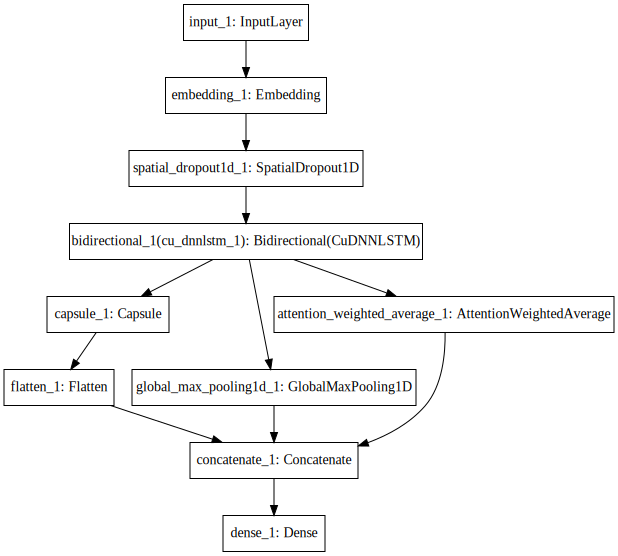

In [20]:
SVG(model_to_dot(sample_model).create(prog='dot', format='svg'))

## Train model with KFold CV and Early Stopping (and generate predictions)

In [21]:
warnings.filterwarnings('ignore')

In [22]:
splits = list(KFold(n_splits=5).split(X_train, y_train))

oof_preds = np.zeros((X_train.shape[0]))
test_preds = np.zeros((X_test.shape[0]))

for fold in [0, 1, 2, 3, 4]:
    K.clear_session()
    tr_ind, val_ind = splits[fold]

    ckpt = ModelCheckpoint(f'gru_{fold}.hdf5', save_best_only = True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model = get_model()

    model.fit(X_train[tr_ind],
              y_train[tr_ind]>0.5,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(X_train[val_ind], y_train[val_ind]>0.5),
              callbacks = [es,ckpt])

    oof_preds[val_ind] += model.predict(X_train[val_ind])[:,0]
    test_preds += model.predict(X_test)[:,0]

test_preds /= 5

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/100
1443899/1443899 [==============================] - 106s 73us/step - loss: 0.1173 - acc: 0.9578 - val_loss: 0.0954 - val_acc: 0.9639
Epoch 2/100
1443899/1443899 [==============================] - 102s 70us/step - loss: 0.0960 - acc: 0.9638 - val_loss: 0.0964 - val_acc: 0.9623
Epoch 3/100
1443899/1443899 [==============================] - 102s 70us/step - loss: 0.0924 - acc: 0.9650 - val_loss: 0.0933 - val_acc: 0.9638
Epoch 4/100
1443899/1443899 [==============================] - 102s 70us/step - loss: 0.0901 - acc: 0.9660 - val_loss: 0.0908 - val_acc: 0.9648
Epoch 5/100
1443899/1443899 [==============================] - 102s 71us/step - loss: 0.0886 - acc: 0.9663 - val_loss: 0.0910 - val_acc: 0.9645
Epoch 6/100
1443899/1443899 [==============================] - 101s 70us/step - loss: 0.0872 - acc: 0

## Prepare submission

In [23]:
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission['prediction'] = test_preds
submission.reset_index(drop=False, inplace=True)
submission.head()

,id,prediction
0,7000000,0.001325
1,7000001,0.000093
2,7000002,0.004239
3,7000003,0.002098
4,7000004,0.979385


In [24]:
submission.to_csv('submission.csv', index=False)